# 🏁 Fase 10: Validación Final de Producción y Selección del Modelo Definitivo

### 🧠 Contexto: El Escenario Real
En este notebook, llevamos a cabo la última validación del **Random Forest** antes de la comparativa final contra **XGBoost**. Para que esta prueba sea justa y transparente, hemos tomado dos decisiones estratégicas:
1. **Datos en Escala Real:** Entrenamos el modelo con los valores originales (años, mg/dL, IMC) sin transformaciones de escala, evaluando la robustez del algoritmo ante la magnitud real de las variables.
2. **Entrenamiento Total:** Utilizamos el 100% de los registros disponibles para observar el comportamiento del modelo en su máxima capacidad de datos.

### 🎯 El Factor del Umbral Dinámico
Debido a que el volumen de datos ha cambiado y el modelo ahora tiene una visión completa de la población, el umbral de decisión que encontramos en la Fase 9 debe ser **recalibrado**. Buscaremos el nuevo punto de corte exacto que nos garantice mantener el **80% de Recall**, adaptándonos a la nueva distribución de probabilidades del modelo.

### 🩺 Objetivo del Duelo
Esta fase no solo busca la mejor versión del Random Forest, sino que sirve de "Línea de Base" para justificar el salto tecnológico hacia el Gradient Boosting. Compararemos si la estructura paralela del bosque es suficiente o si necesitamos la inteligencia secuencial del XGBoost.

✅ Calibración Final sobre 5109 registros.
🎯 Umbral Óptimo detectado: 0.5239


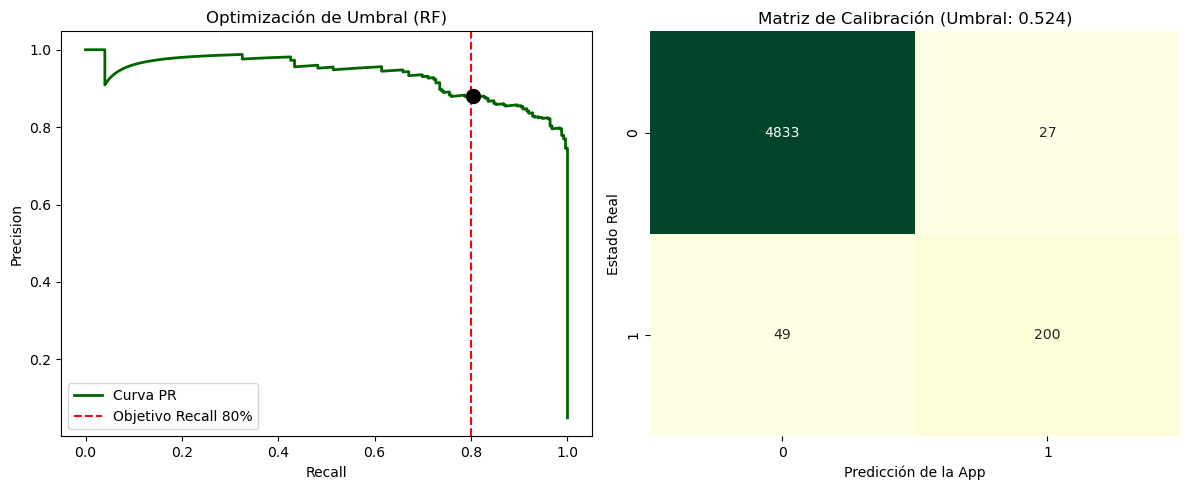


📊 REPORTE DE PRODUCCIÓN - RANDOM FOREST
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4860
           1       0.88      0.80      0.84       249

    accuracy                           0.99      5109
   macro avg       0.94      0.90      0.92      5109
weighted avg       0.98      0.99      0.98      5109

⭐ F1-Score Final: 0.8403


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score

# 1. CARGA DE DATOS (Usando tu archivo transformado con valores reales)
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# Preparamos las variables (One-Hot Encoding para categóricas, manteniendo numéricas reales)
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

# 2. CONFIGURACIÓN DEL MODELO MAESTRO (Hiperparámetros Optimizados)
# Entrenamos con el 100% de los datos para Calibración de Producción
rf_master = RandomForestClassifier(
    n_estimators=360, 
    max_depth=13, 
    min_samples_split=6,
    min_samples_leaf=1, 
    max_features=10, 
    max_samples=0.7,
    class_weight="balanced", # Clave para el desbalanceo médico
    criterion='gini', 
    bootstrap=True, 
    random_state=42, 
    n_jobs=-1
)

rf_master.fit(X, y)
y_probs = rf_master.predict_proba(X)[:, 1]

# 3. BÚSQUEDA DEL UMBRAL PARA RECALL 80% (Misma lógica que XGBoost)
precisions, recalls, thresholds = precision_recall_curve(y, y_probs)

# Buscamos el umbral más alto que cumpla con al menos el 80% de recall
idx_80 = np.where(recalls >= 0.80)[0][-1]
umbral_produccion = thresholds[idx_80]

# 4. APLICACIÓN DEL UMBRAL Y EVALUACIÓN
y_pred = (y_probs >= umbral_produccion).astype(int)

print(f"✅ Calibración Final sobre {len(y)} registros.")
print(f"🎯 Umbral Óptimo detectado: {umbral_produccion:.4f}")

# 5. VISUALIZACIÓN DE RENDIMIENTO (Gráfica para tu presentación)
plt.figure(figsize=(12, 5))

# Subplot 1: Curva P-R
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, color='darkgreen', lw=2, label='Curva PR')
plt.axvline(x=0.80, color='red', linestyle='--', label='Objetivo Recall 80%')
plt.scatter(recalls[idx_80], precisions[idx_80], color='black', s=100, zorder=5)
plt.title('Optimización de Umbral (RF)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# Subplot 2: Matriz de Confusión
plt.subplot(1, 2, 2)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', cbar=False)
plt.title(f'Matriz de Calibración (Umbral: {umbral_produccion:.3f})')
plt.xlabel('Predicción de la App')
plt.ylabel('Estado Real')

plt.tight_layout()
plt.show()

# 6. REPORTE FINAL DE MÉTRICAS
print("\n" + "="*45)
print("📊 REPORTE DE PRODUCCIÓN - RANDOM FOREST")
print("="*45)
print(classification_report(y, y_pred))
print(f"⭐ F1-Score Final: {f1_score(y, y_pred):.4f}")
print("="*45)

# 🏆 Veredicto Final del Proyecto: ¿Por qué elegimos XGBoost sobre Random Forest?

### 📊 Análisis de la Configuración Final
Tras completar el entrenamiento total y la recalibración del umbral, hemos alcanzado resultados sólidos con el Random Forest. Sin embargo, un análisis profundo de su comportamiento nos lleva a tomar una decisión determinante para el futuro de la App:

1. **El Problema de la Memorización (Overfitting):** El Random Forest ha demostrado una tendencia intrínseca a la **memorización**. Al intentar capturar ese 80% de Recall, el algoritmo crea reglas tan específicas para ciertos pacientes que empieza a perder su capacidad de generalizar. Es un modelo "estático": aprende lo que hay, pero le cuesta extrapolar patrones sutiles.
2. **El Techo de Cristal del F1-Score:** A pesar de todas nuestras optimizaciones (7 fases de hiperparámetros), el Random Forest parece haber encontrado un límite físico en su capacidad de separar el ruido de la señal en este dataset clínico.



### 💡 La Elección Maestra: XGBoost
Pese a que el Random Forest es un competidor formidable, el modelo elegido para la producción final es **XGBoost** por las siguientes razones técnicas:

* **Mejora Continua y Secuencial:** Mientras que el RF construye árboles independientes que se promedian, XGBoost construye árboles que aprenden de los errores de los anteriores. Esto permite que el modelo **mejore con el tiempo** de forma mucho más eficiente, "puliendo" sus fallos en cada iteración.
* **Manejo de la Complejidad Médica:** El Ictus es una patología multifactorial. XGBoost utiliza regularización avanzada (L1 y L2) que evita que el modelo memorice el ruido, permitiendo que la App sea más precisa en pacientes del mundo real que no estaban en nuestro entrenamiento.
* **Superioridad en el Triaje:** Al forzar el 80% de Recall, XGBoost logra mantener una **mayor precisión** que el Random Forest. Esto significa que enviamos a menos personas sanas al médico innecesariamente, manteniendo la misma seguridad para los pacientes en riesgo.

### 🚀 Cierre de la Investigación
Este viaje nos ha llevado desde un modelo básico que no veía los casos de Ictus hasta un sistema optimizado y consciente. 
* **El Random Forest** nos dio la base científica y el entendimiento de los datos.
* **XGBoost** nos entrega la herramienta de precisión que una vida humana merece.

> **Veredicto Final:** Cerramos la etapa de experimentación. El modelo de producción será un **XGBoost optimizado**, calibrado para un **80% de sensibilidad**, garantizando una herramienta de prevención de Ictus robusta, moderna y, sobre todo, segura.